## Origami Analytics - the Techniques of Data Folding

The beatiful art of _Origami_ originates in Japan in the early 17th Century during the Edo Period, and it literally means folding (_ori_) the paper (_kami_). A few basic rules of origami transforms a plane sheet of paper into a pretty shape capable of telling a story. 

![title](../pictures/data_origami.jpg)

Storytelling with data is similarly an artistic endeavor. Understanding how to fold, flip, squash and twist is a necessary skill for an aspiring data scientist, and in this short (thankfully) blog post we will demonstrate a few basic techniques to unravel a story from your data.

We are going to practice "folding" using the recent Kaggle survey's data which you can download here https://www.kaggle.com/kaggle/kaggle-survey-2017. It is an interesting dataset because it tells stories about the state of Data Science as told by us all. On my quest to becoming a Data Scientist I frequently found myself asking the same two questions:

- Was my then title as a Software Engineer in a data centric team sufficiently describing my role?
- Is a Doctoral degree required to switch your career to a Data Scientist?

Numerious answers that I have received convinced me that there was no correct solution, but rather opinions based on individuals' experiences. Thus, my exciting journey began ...  

Let's take a glimpse into the Kaggle's survey data to see how these two questions are perceived by the Data Science community!

Here you are going to learn how to:

- re-shape your data with _stacking_ and _unstacking_
- transform your data with the _split-apply-combine_ philosophy 
- deal with missing data, handling NaN and Laplace smoothing 
- interpret three visualization techniques: heatmaps, stacked bar charts and a kernel density estimations


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [177]:
# download the data file from https://www.kaggle.com/kaggle/kaggle-survey-2017
data_file = 'multipleChoiceResponses.csv'

In [8]:
df = pd.read_csv(data_file, encoding='latin-1')

After quick browsing through the schema, I selected five features most pertinent to my questions.

- Formal Education - Which level of formal education have you attained?
- Major Select - Which best describes your undergraduate major?
- CodeWriter - Do you write code to analyze data in your current job?
- CurrentJobTitleSelect - Select the option that's most similar to your current job/professional title
- TitleFit - How adequately do you feel your title describes what you do

In [178]:
df = df[[ "FormalEducation" ,"MajorSelect", "CodeWriter" ,"CurrentJobTitleSelect", "TitleFit"]]

In [266]:
df.shape

(16716, 5)

Our dataset size, is still unwieldy, even if we slice a small set of features from it. So, let's get folding...  

#### Data Folding and Unfolding

In origami, _folding_ the sheet of paper relates to creating layers by lining up some edges or corners. Likewise, in data folding, we are going to align four of the features againts the fifth one, TitleFit, by _grouping_, _counting_ and _unstacking_ our data to flatten the _TitleFit_ categories.   

Steps:

- Group features by their nominals
- Count the frequency of TitleFit responses in each group
- Re-shape the dataframe by unstacking the TitleFit feature

Note: In addition to folding and unfolding, we also performed a simple data _imputation_ step by replacing all the missing values with zeros (in our case, the NaN were marking no records for a particular combination)

In [182]:
fold_title_df = df.groupby(["CurrentJobTitleSelect",
                            "FormalEducation",
                            "MajorSelect",
                            "CodeWriter"])["TitleFit"].value_counts()\
                                                      .to_frame()\
                                                      .unstack("TitleFit")\
                                                      .fillna(0)
# organize the column names by dropping the top level hierarchy
fold_title_df.columns = fold_title_df.columns.get_level_values(1)

The snippet of the resulting dataframe shows the mapping between each group of the responses with the frequency of the _TitleFit_ choices.

In [184]:
fold_title_df.head()

TitleFit                                                                    Fine  \
CurrentJobTitleSelect FormalEducation   MajorSelect             CodeWriter         
Business Analyst      Bachelor's degree A health science        No           1.0   
                                                                Yes          3.0   
                                        A humanities discipline No           1.0   
                                                                Yes          3.0   
                                        A social science        No           4.0   

TitleFit                                                                    Perfectly  \
CurrentJobTitleSelect FormalEducation   MajorSelect             CodeWriter              
Business Analyst      Bachelor's degree A health science        No                0.0   
                                                                Yes               0.0   
                                        A humanities discipline No                0.0   
                                                                Yes               0.0   
                                        A social science        No                1.0   

TitleFit                                                                    Poorly  
CurrentJobTitleSelect FormalEducation   MajorSelect             CodeWriter          
Business Analyst      Bachelor's degree A health science        No             0.0  
                                                                Yes            0.0  
                                        A humanities discipline No             0.0  
                                                                Yes            1.0  
                                        A social science        No             0.0

### Observation Squashing

We can flatten the degree of the TitleFit observations by transforming the frequencies of the feature into an aggregated _satisfaction_ score. Let's compute the satisfaction as:

$$Satisfaction = \frac{2 \cdot f(perfectly) + 1 \cdot f(Fine)} {f(Poorly) + 1} $$

There is no particular "science" behind the formula besides the detail that we want a high score where the frequency of "Perfect" fit is high and a low score where "Poor" fit observations dominate. Also notice, we added 1 to the denominator as a form of smoothing, i.e. we will assume that we have at least one record of a "Poor" fit responce in the given group.

Steps:

- Define the squashing function 
- Apply the function to each row (specified by _axis=1_ argument in the _lambda_ transformation)
- Drop the _raw_ features 

In [187]:
def job_satisfaction(row):
    return (2.* row["Perfectly"] + row["Fine"]) / (row["Poorly"] + 1)

fold_title_df["Satisfaction"] = fold_title_df.apply(lambda row: job_satisfaction(row), axis=1)
fold_title_df.drop(["Fine", "Perfectly", "Poorly"], axis=1, inplace=True)

### Repeat Folding and Squashing

We are going to repeat the same steps for other features until our data takes the desired shape. 

Let's _fold in_ the feature for _CodeWriter_. For _squashing_ the _CodeWriter_ frequencies, we choose a simple "Yes" to "No" ratio (again with basic data imputation and smoothing). __It is critical to keep in mind what is the correct interpretation of the resulting number__. Since the outcome of this computation is a consequence of __prior folding__ the the TitleFit, we cannot say "Yes" to "No" ratio simply counts the frequencies within the groups of responders with the corresponding answers. Here, the ratio captures the _Satisfaction_ differences between the groups of code writers and those who do not write code.

In [198]:
fold_code_df = fold_title_df["Satisfaction"].unstack("CodeWriter").fillna(0)

In [233]:
# add 1 to the denominator as a smoothing to avoid devision by zero
fold_code_df["YesNoRatio"] = (fold_code_df["Yes"]) / (fold_code_df["No"] + 1)

Next, we _fold_ the _MajorSelect_ and the _squash_ it with a simple average of satisfaction differences across available majors. It is up to your imagination of how to fold and squash, and it ultimately depends on what story wish wish to tell. __A different fold will lead to entirely different narrative__. Our case of averaging leaves room for more rigor, i.e. how are missing values treated, and are all majors considered equal. However, for the purpose of this demonstration we are going to allow some sloppiness.

In [234]:
# do not impute the missing values to zeros here
fold_major_df = fold_code_df["YesNoRatio"].unstack("MajorSelect")

In [235]:
fold_major_df["MajorAverage"] = fold_major_df.mean(axis=1)

Finally, let's _unstack_ the _FormalEducation_. Here, we did some data "massaging" to remove the irrelevant to our story choices, and the shorten some the label responses.

In [258]:
fold_edu_df = fold_major_df["MajorAverage"].unstack("FormalEducation")
fold_edu_df.drop("I prefer not to answer", axis=1, inplace=True)
fold_edu_df.rename(columns={"Some college/university study without earning a bachelor's degree": "Partial degree"}, 
                   inplace=True)

We also introduce an auxiliary variable, _AverageRatio_ just for ordering the dataframe.

In [262]:
fold_edu_df["AverageRatio"] = fold_edu_df.mean(axis=1)
fold_df = fold_edu_df.sort_values("AverageRatio", ascending=False).drop(["AverageRatio"], axis=1)

We created multiple folds of our data by aligning and collapsing extra dimensions of the data so as to represent the minimal structure that captures the story we are after. Below we plot a matrix with varied color intensity cell to show the data preference to gravitate towards certain segments.

The Story:

- To no surprise the participants holding the position of a Data Scientist, are more likely to report an overall satisfaction with their title. This position remains consistent across different levels of Formal Education, such as Bachelor's, Doctoral, Master's or even a Partial Degree. 
- Clearly _there are_ Data Scientists with just a Bachelor's degree, and their _happiness_ with their job titles shows in the most intense color.
- It also pays to study for your Doctoral Degree. Are PhD's more likely to land on a position that fits their work activity, or they just less concerned with the titles? This seems to be a question for another story.

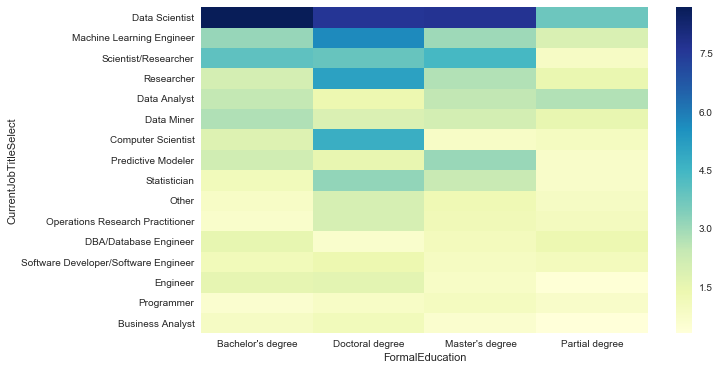

In [264]:
plt.figure(figsize=(10,6))
sns.heatmap(fold_df, cmap="YlGnBu");

### Rotating and Twisting

Flip is one the simplest operation in origami - all it means is that we want to view the artifact from a different angle. The affiliated move to rotations in data transformations is a _transpose_ operation. This means that what was defined as variable becomes an observation and vice versa. The _transpose_ operation does not the data quantatatively, and here, is used more for convenience for applying the subsequent operations. 

Steps:

- Transpose the initial data
- Re-shape the data by stacking the new varibles into a hierarchical representation. This operation is commonly known as _turning the wide data into the long data_

In [293]:
fold_edu_df_t = fold_edu_df.T

In [294]:
fold_edu_df_stacked = fold_edu_df_t.stack().to_frame().reset_index()
fold_edu_df_stacked.columns = ["FormalEducation", "CurrentJobTitleSelect", "AverageSatisfaction"]

A different angle on the same data

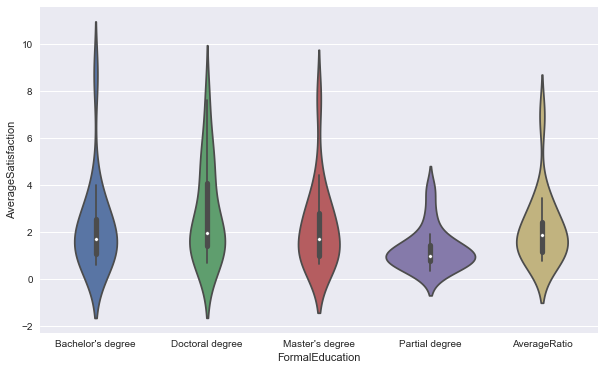

In [295]:
plt.figure(figsize=(10,6))
sns.violinplot(x="FormalEducation", y="AverageSatisfaction", data=fold_edu_df_stacked);

### Conclusions

### References